# File Info

Point of file is learning $\dot x = f_\theta(x(t), \lambda(t))$

Learning Standard Hopf Bifurcation with linearly increasing bifurcation parameter - increase network size compared to v5

Model saved as hopf_node_model_v6

In [ ]:
import os
import sys
from torchdiffeq import odeint as odeint

sys.path.append(os.path.abspath(".."))

import numpy as np  
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider
import types

import Neural_ODEs_v1 as nodes
import models.DynamicalSystems as ds

: 

# Data Geneation

Hopf Bifurcation

$\alpha > 0$ for supercritical

$\alpha < 0$ for subcritical

$$ 
\begin{aligned}
\dot r = r (\rho + \alpha r^2) \\
\dot \theta = \omega + \beta r^2
\end{aligned}
$$

fixed points at $r = 0$ and $r = \sqrt{\frac{-\rho}{\alpha}}$


In [ ]:
class Hopf(ds.DynamicalSystem_torch):
    def __init__(self, rho=1.0, alpha=1.0, omega = 1.0, beta=1.0):
        super().__init__()
        self.rho = rho 
        self.alpha = alpha
        self.beta = beta
        self.omega = omega
        self.gamma = 0.1 #Rate of change of bifurcation parameter
        self.system_dim = 2


    def f(self, t, x): 
        #x sould be (traj, dim)
        if not isinstance(x, torch.Tensor):
            raise TypeError(f"Expected torch.Tensor, got {type(x)}")
        elif len(x.shape) == 1:
            if x.shape[0] != self.system_dim: 
                raise ValueError("x must have dimension of 2")
            else:
                x = x.unsqueeze(0)
        elif len(x.shape) == 2: 
            if x.shape[1] != self.system_dim: 
                raise ValueError("x.shape[1] must have dimension of ", self.system_dim)
        else:
            raise ValueError("Input tensor x cannot have more than 2 dimensions (trajectory, dimension)")
        
        xdot = self.rho * x[:, 0] - self.omega * x[:, 1] + (self.alpha*x[:, 0] - self.beta * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #traj
        ydot = self.omega * x[:, 0] + self.rho * x[:, 1] + (self.beta*x[:, 0] + self.alpha * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #(traj)
        return torch.cat([xdot.unsqueeze(1), ydot.unsqueeze(1)], dim = 1)
    
    def na_f(self, t, x):
        xdot = x[:, 2] * x[:, 0] - self.omega * x[:, 1] + (self.alpha*x[:, 0] - self.beta * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #traj
        ydot = self.omega * x[:, 0] + x[:, 2] * x[:, 1] + (self.beta*x[:, 0] + self.alpha * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #(traj)
        rdot = self.gamma*torch.ones_like(x[:, 0]) #Rate of change of bifurcation parameter
        return torch.cat([xdot.unsqueeze(1), ydot.unsqueeze(1), rdot.unsqueeze(1)], dim = 1)


: 

In [ ]:
lc = Hopf(rho=1.0, alpha=-1.0, beta=0.0)
#Supercritical hopf 

: 

In [ ]:
y0 = torch.tensor([[1.0, 0.0, 1.0], [0.0, 1.0, 1.0], [0.0, 0.0, 1.0]])
y0.shape

: 

In [ ]:
lc.na_f(t = 0, x = y0).shape

: 

In [ ]:
sol = odeint(func=lc.na_f, y0=y0, t=torch.arange(0, 10, 0.1), method='rk4')

: 

In [ ]:
a = torch.arange(-2.0, 2.0, 0.5); b = torch.arange(-2, 2, 0.5); c = torch.ones_like(a)
ic = torch.cartesian_prod(a, b, torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0]))  #traj, dim


t_span = (0, 10); dt = 0.05
ic.shape #traj, dim


: 

In [ ]:
lc.f = lc.na_f

: 

In [ ]:
sol = lc.solve(x0=ic, t_span=t_span, dt=dt) #(time, traj, dim  )


: 

In [ ]:
for i in range(ic.shape[0]):
    plt.plot(sol[:, i, 0], sol[:, i, 1])

: 

In [ ]:
training_data_tensor = sol.unsqueeze(0)
t_eval_tensor = torch.tensor( np.arange(t_span[0], t_span[1], dt), dtype=torch.float32 ).unsqueeze(0)

: 

In [ ]:
print(training_data_tensor.shape, t_eval_tensor.shape)

: 

# Neural ODE - 

In [ ]:
class NODE(nodes.Simple_FeedforwardNN):
    '''
    Class that creates an Neural ODE. 
    '''
    def __init__(self, input_dim: int, output_dim: int, depth: int, width: int, activation_func: nn.Module = nn.Tanh()):
        super().__init__(input_dim=input_dim, depth=depth, width=width, output_dim=output_dim, activation_func=activation_func)
        if input_dim < output_dim:
            raise ValueError("Input dimension must be greater than or equal to output dimension in a neural ODE.")
        else:
            self.width              = width #width is number of neurons per hidden layer
            self.depth              = depth #Number of internal hidden layers
            self.input_dim         = input_dim
            self.output_dim        = output_dim
            self.activation_func   = activation_func
    

    


    def forward(self, t, x): #x shoudl be (num_traj, spatial_dim)
        '''Takes t and x as input, where x is a pytorch tensor with shape: [trajectories, dim].'''
        out = self.network(x) #(num_traj, spatial_dim+drivers)
        return out

: 

In [ ]:
model = NODE(input_dim=lc.system_dim+1, output_dim=lc.system_dim+1, depth=8, width=40, activation_func=nn.Tanh())  

: 

In [ ]:
#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()




: 

In [ ]:
training_data_tensor.shape, t_eval_tensor.shape

: 

In [21]:
num_epochs = 1000


for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()

    # Predicting the trajectory
    pred_x_list = []
    for i in range(t_eval_tensor.shape[0]):
        pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :], t_eval_tensor[i, :], method='rk4', options={'step_size': dt})
        pred_x_list.append(pred_x_temp)

    pred_x = torch.stack(pred_x_list, dim=0)

    # Calculating loss
    loss = loss_fn(pred_x, training_data_tensor) 
    loss_list.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

  0%|          | 1/1000 [00:03<52:57,  3.18s/it]

Epoch 0, Loss: 7.713211536407471


  2%|▏         | 21/1000 [01:00<54:54,  3.37s/it]

Epoch 20, Loss: 1.2430400848388672


  4%|▍         | 41/1000 [01:53<25:11,  1.58s/it]  

Epoch 40, Loss: 1.0930330753326416


  6%|▌         | 61/1000 [02:19<20:31,  1.31s/it]

Epoch 60, Loss: 1.038899540901184


  8%|▊         | 81/1000 [02:45<20:04,  1.31s/it]

Epoch 80, Loss: 0.9942599534988403


 10%|█         | 101/1000 [03:12<19:39,  1.31s/it]

Epoch 100, Loss: 0.8441889882087708


 12%|█▏        | 121/1000 [03:38<20:45,  1.42s/it]

Epoch 120, Loss: 0.7446274161338806


 14%|█▍        | 141/1000 [04:06<18:57,  1.32s/it]

Epoch 140, Loss: 0.6363309621810913


 16%|█▌        | 161/1000 [04:32<18:02,  1.29s/it]

Epoch 160, Loss: 0.3390977680683136


 18%|█▊        | 181/1000 [04:59<17:44,  1.30s/it]

Epoch 180, Loss: 0.12290681153535843


 20%|██        | 201/1000 [05:25<17:49,  1.34s/it]

Epoch 200, Loss: 0.06825578957796097


 22%|██▏       | 221/1000 [05:53<17:27,  1.34s/it]

Epoch 220, Loss: 0.050652723759412766


 24%|██▍       | 241/1000 [06:20<18:34,  1.47s/it]

Epoch 240, Loss: 0.04258490353822708


 26%|██▌       | 261/1000 [06:51<18:34,  1.51s/it]

Epoch 260, Loss: 0.037395115941762924


 28%|██▊       | 281/1000 [07:18<16:09,  1.35s/it]

Epoch 280, Loss: 0.035007644444704056


 30%|███       | 301/1000 [07:45<15:24,  1.32s/it]

Epoch 300, Loss: 0.031374190002679825


 32%|███▏      | 321/1000 [08:12<15:02,  1.33s/it]

Epoch 320, Loss: 0.02677128277719021


 34%|███▍      | 341/1000 [08:38<14:30,  1.32s/it]

Epoch 340, Loss: 0.028177408501505852


 36%|███▌      | 361/1000 [09:06<14:59,  1.41s/it]

Epoch 360, Loss: 0.021987948566675186


 38%|███▊      | 381/1000 [09:33<13:44,  1.33s/it]

Epoch 380, Loss: 0.028937017545104027


 40%|████      | 401/1000 [10:00<13:16,  1.33s/it]

Epoch 400, Loss: 0.022280586883425713


 42%|████▏     | 421/1000 [10:28<14:38,  1.52s/it]

Epoch 420, Loss: 0.018144981935620308


 44%|████▍     | 441/1000 [10:57<13:16,  1.42s/it]

Epoch 440, Loss: 0.021034622564911842


 46%|████▌     | 461/1000 [11:25<12:27,  1.39s/it]

Epoch 460, Loss: 0.017832931131124496


 48%|████▊     | 481/1000 [11:52<11:46,  1.36s/it]

Epoch 480, Loss: 0.023649374023079872


 50%|█████     | 501/1000 [12:20<11:45,  1.41s/it]

Epoch 500, Loss: 0.01841050200164318


 51%|█████     | 508/1000 [12:31<12:07,  1.48s/it]


KeyboardInterrupt: 

In [22]:
torch.save(model, 'hopf_node_model_v6.pth')

In [ ]:
model = torch.load('hopf_node_model_v6.pth', weights_only=False)


: 

In [ ]:
pred_x_list = []
for i in range(t_eval_tensor.shape[0]):
    pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :], t_eval_tensor[i, :], method='rk4', options={'step_size': dt})
    pred_x_list.append(pred_x_temp)

pred_x = torch.stack(pred_x_list, dim=0)

loss_fn(pred_x, training_data_tensor)


: 

In [ ]:
# Analysis of Trained Model

In [ ]:
plt.plot(pred_x)

C:\Users\jackr\AppData\Local\Temp\ipykernel_29960\3146670159.py:11: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(0, epochs)


Text(0.5, 0, 'Epochs')

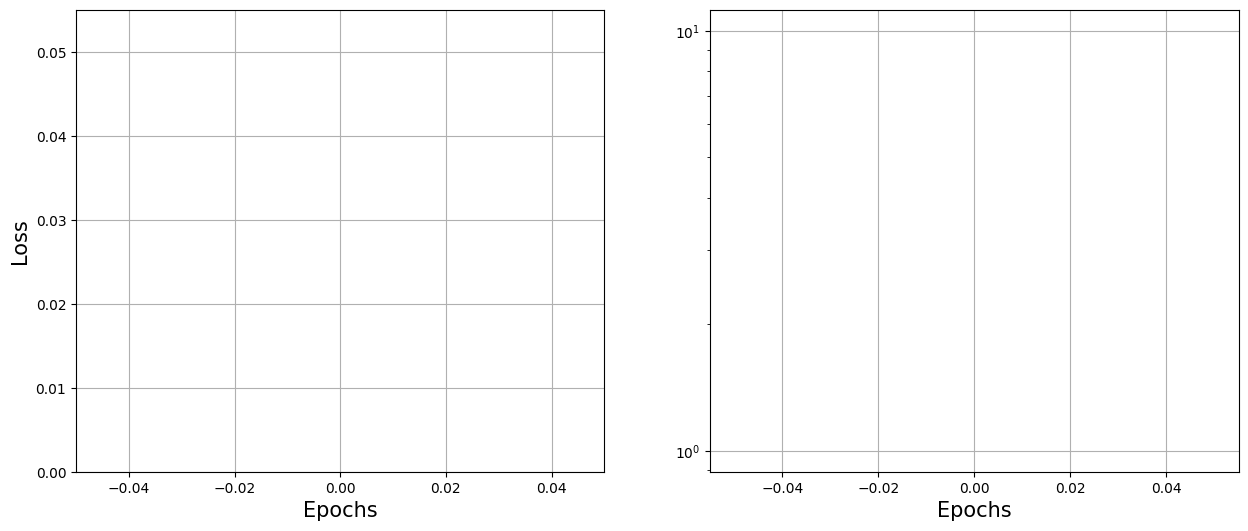

In [18]:
### Analysis  
epochs = len(loss_list)
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])

#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

torch.Size([110])

In [19]:
r_vals = torch.arange(-1.0, 10.0, 0.1)

a = torch.linspace(-2, 2, 10)  
b = torch.linspace(-2, 2, 10)  

pts = torch.cartesian_prod(a, b, r_vals)

t_Start_pred = 0; t_Final_pred = 20; dt_pred = 0.05
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt_pred)
node_data = odeint(model, pts.float(), t_eval_pred, method='rk4', options={'step_size': dt_pred})
true_data = odeint(func=lc.na_f, y0=pts, t=t_eval_pred, method='rk4', options={'step_size': dt_pred})

In [21]:
true_data.shape

torch.Size([400, 11000, 3])

#Plotting results
fig = plt.figure(figsize=(10, 8))

#First Plot
ax1 = fig.add_subplot(1, 2, 1)
for i in range(pts.shape[0]):
    ax1.arrow(x=true_data[0, i, 0].detach().numpy(), y=true_data[0, i, 1].detach().numpy(), 
          dx=true_data[10, i, 0].detach().numpy() - true_data[0, i, 0].detach().numpy(), 
          dy=true_data[10, i, 1].detach().numpy() - true_data[0, i, 1].detach().numpy(), length_includes_head=True, head_width=0.05, head_length=0.1, color='gray')


#ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)


#Second Plot 
ax2 = fig.add_subplot(1, 2, 2)
for i in range(pts.shape[0]):
    ax2.arrow(x=node_data[0, i, 0].detach().numpy(), y=node_data[0, i, 1].detach().numpy(), 
          dx=node_data[10, i, 0].detach().numpy() - node_data[0, i, 0].detach().numpy(), 
          dy=node_data[10, i, 1].detach().numpy() - node_data[0, i, 1].detach().numpy(), length_includes_head=True, head_width=0.05, head_length=0.1, color='gray')

    



plt.show()

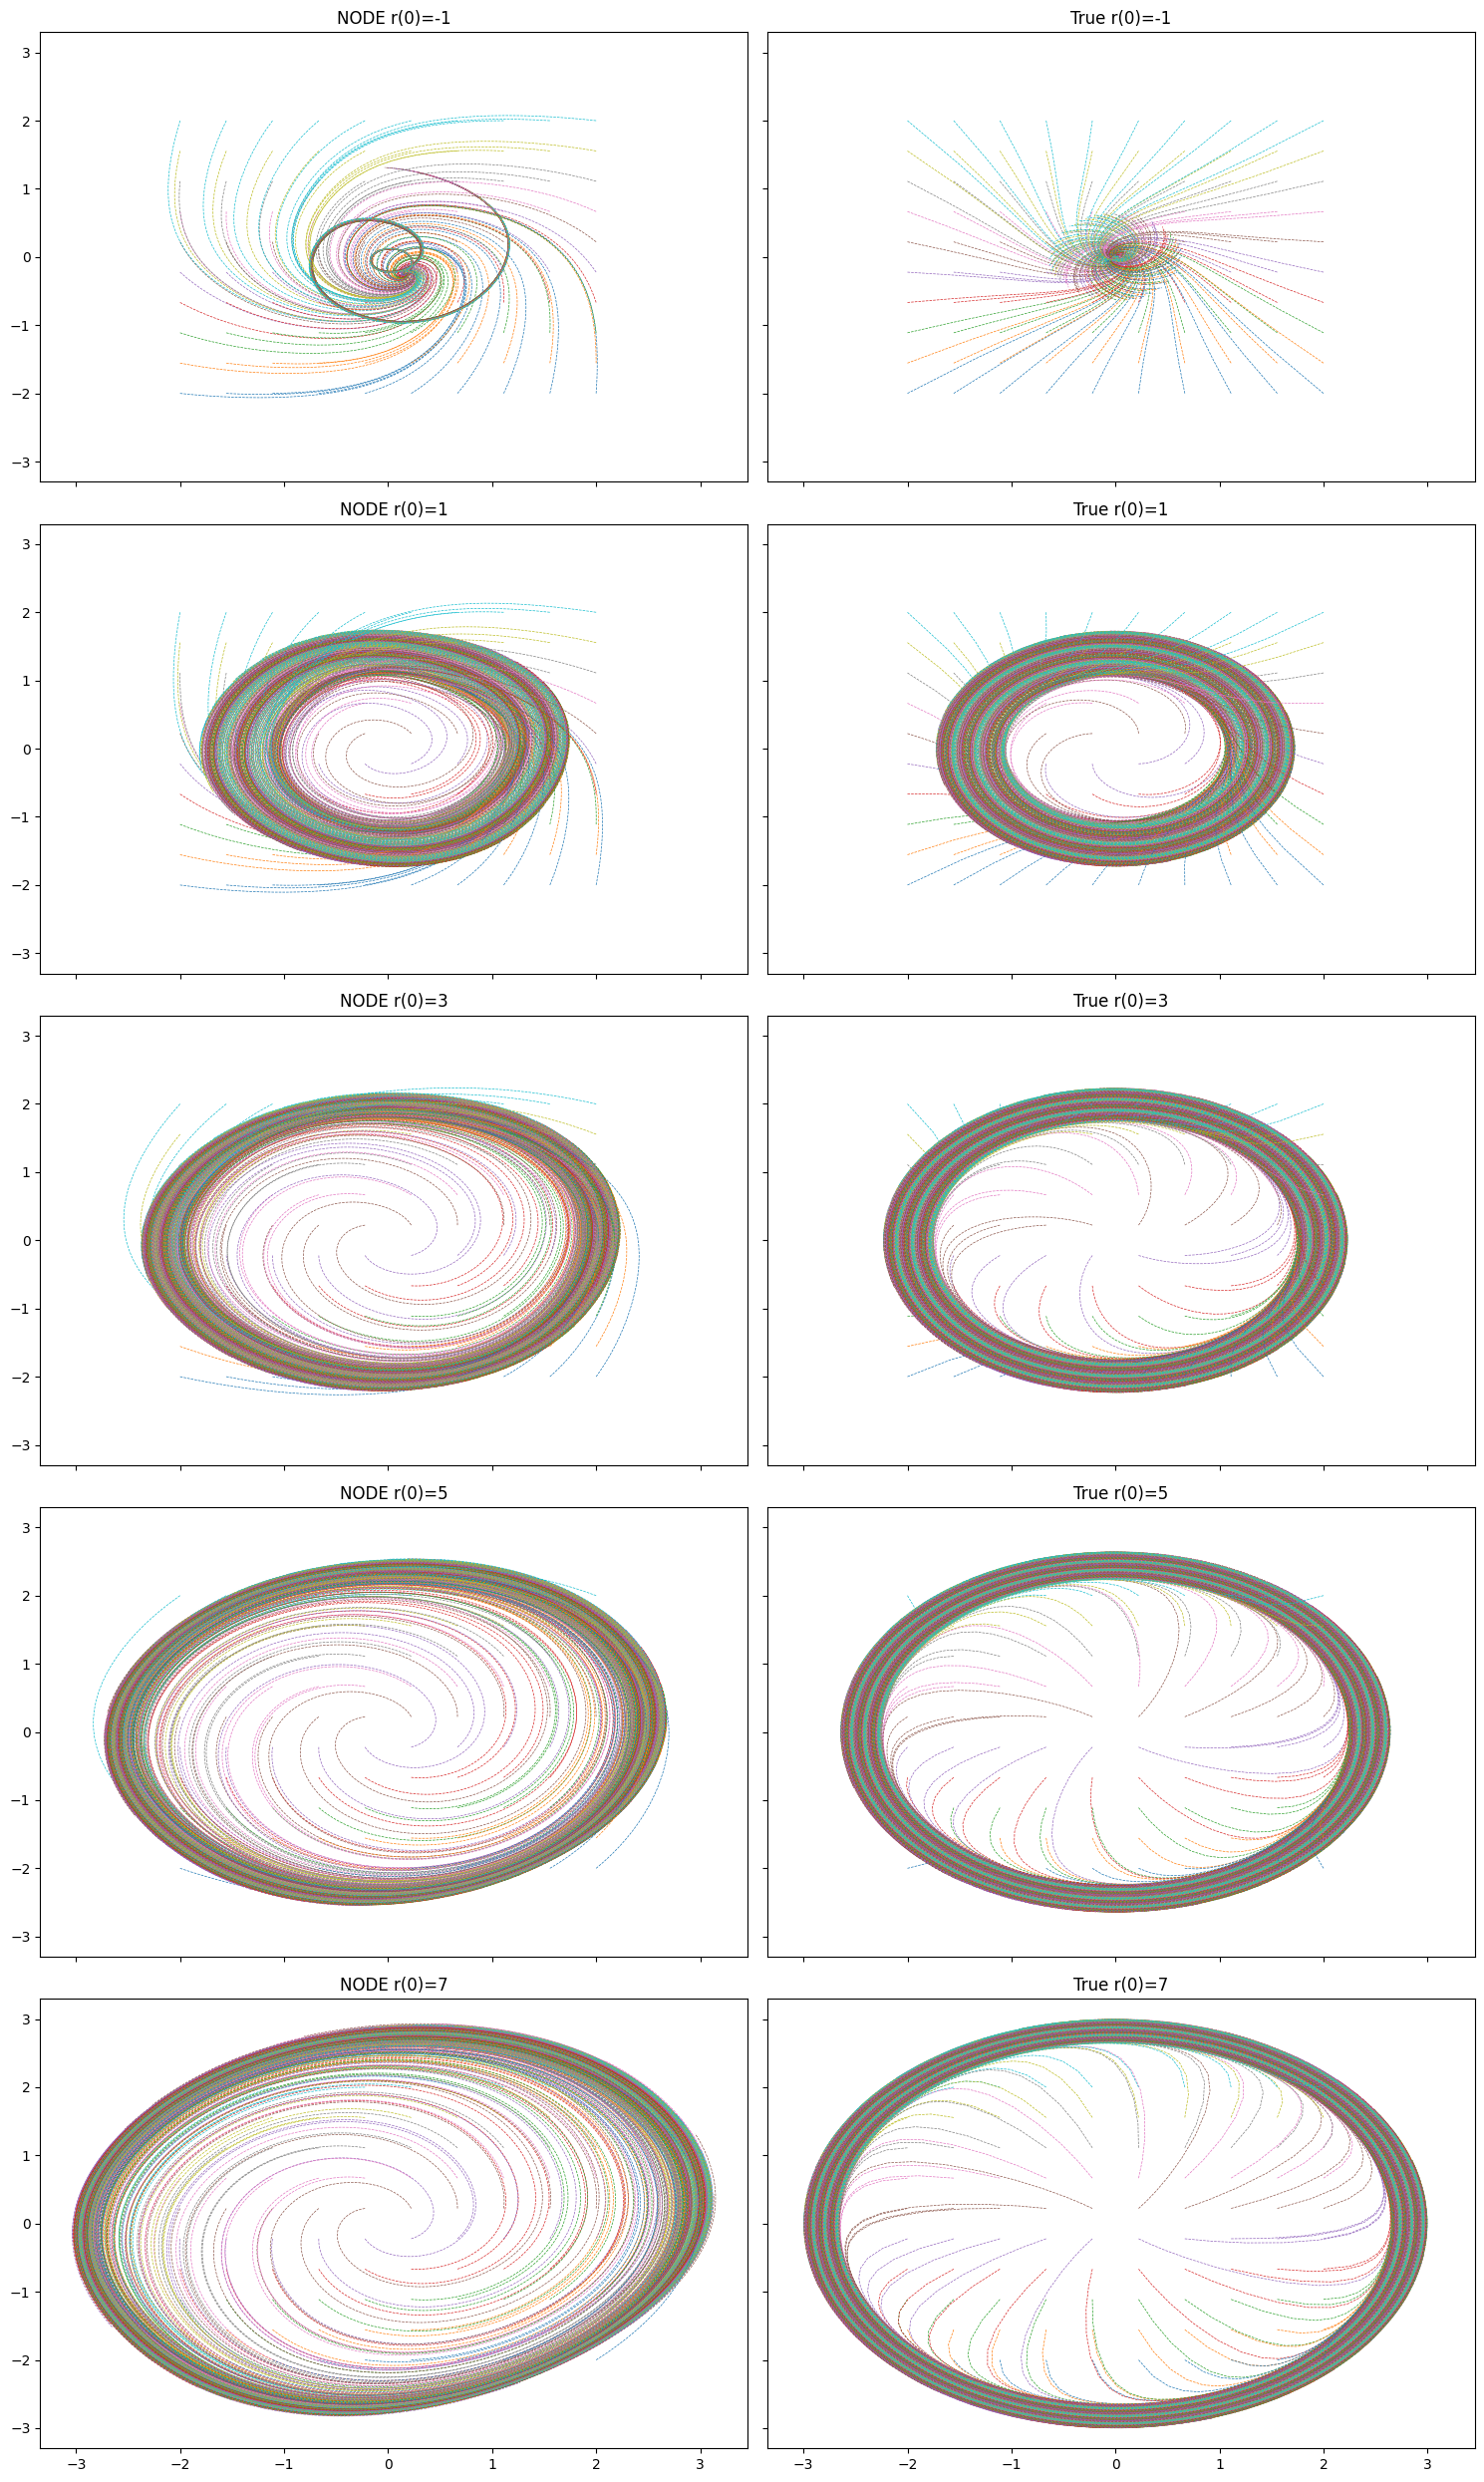

In [20]:
r_plots = [-1, 1, 3, 5, 7]
fig, axes = plt.subplots(len(r_plots), 2, figsize=(15, 5*len(r_plots)), sharex=True, sharey=True)

for i, r in enumerate(r_plots):
    axes[i, 0].plot(node_data[:, pts[:, 2] == r, 0].detach().numpy(),
                    node_data[:, pts[:, 2] == r, 1].detach().numpy(),
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 1].plot(true_data[:, pts[:, 2] == r, 0].detach().numpy(),
                    true_data[:, pts[:, 2] == r, 1].detach().numpy(),
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 0].set_title(f"NODE r(0)={r}")
    axes[i, 1].set_title(f"True r(0)={r}")

plt.tight_layout()
plt.show()

In [372]:
pts.shape

torch.Size([11000, 3])

In [22]:
# Interactive trajectory plot
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt

def plot_traj(idx=0):
    fig = plt.figure(figsize=(15, 8))
    r_val = r_vals[idx]
    print('rho = ', r_val.float())
    #First Plot
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(node_data[:, pts[:, 2] == r_val, 0].detach().numpy(), node_data[:, pts[:, 2] == r_val, 1].detach().numpy(), linewidth=0.5, alpha=1, linestyle='--')

    ax1 = fig.add_subplot(1, 2, 2)
    ax1.plot(true_data[:, pts[:, 2] == r_val, 0].detach().numpy(), true_data[:, pts[:, 2] == r_val, 1].detach().numpy(), linewidth=0.5, alpha=1, linestyle='--')


In [23]:
interact(plot_traj, idx=IntSlider(min=0.0, max=r_vals.shape[0]-1, step=1))

interactive(children=(IntSlider(value=0, description='idx', max=109), Output()), _dom_classes=('widget-interac…

<function __main__.plot_traj(idx=0)>

# Static $\rho $

In [23]:
def odewrapper(t, x):
    out = model(t, x)
    #out[:, 2] = torch.zeros_like(out[:, 2])
    out[:, 2] = 2*out[:, 2]
    return out

In [ ]:
r_vals = torch.arange(-1.0, 10.0, 0.1)

a = torch.linspace(-2, 2, 10)  
b = torch.linspace(-2, 2, 10)  

pts = torch.cartesian_prod(a, b, r_vals)

t_Start_pred = 0; t_Final_pred = 20; dt_pred = 0.05
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt_pred)
node_data = odeint(odewrapper, pts.float(), t_eval_pred, method='rk4', options={'step_size': dt_pred})
true_data = odeint(func=lc.na_f, y0=pts, t=t_eval_pred, method='rk4', options={'step_size': dt_pred})

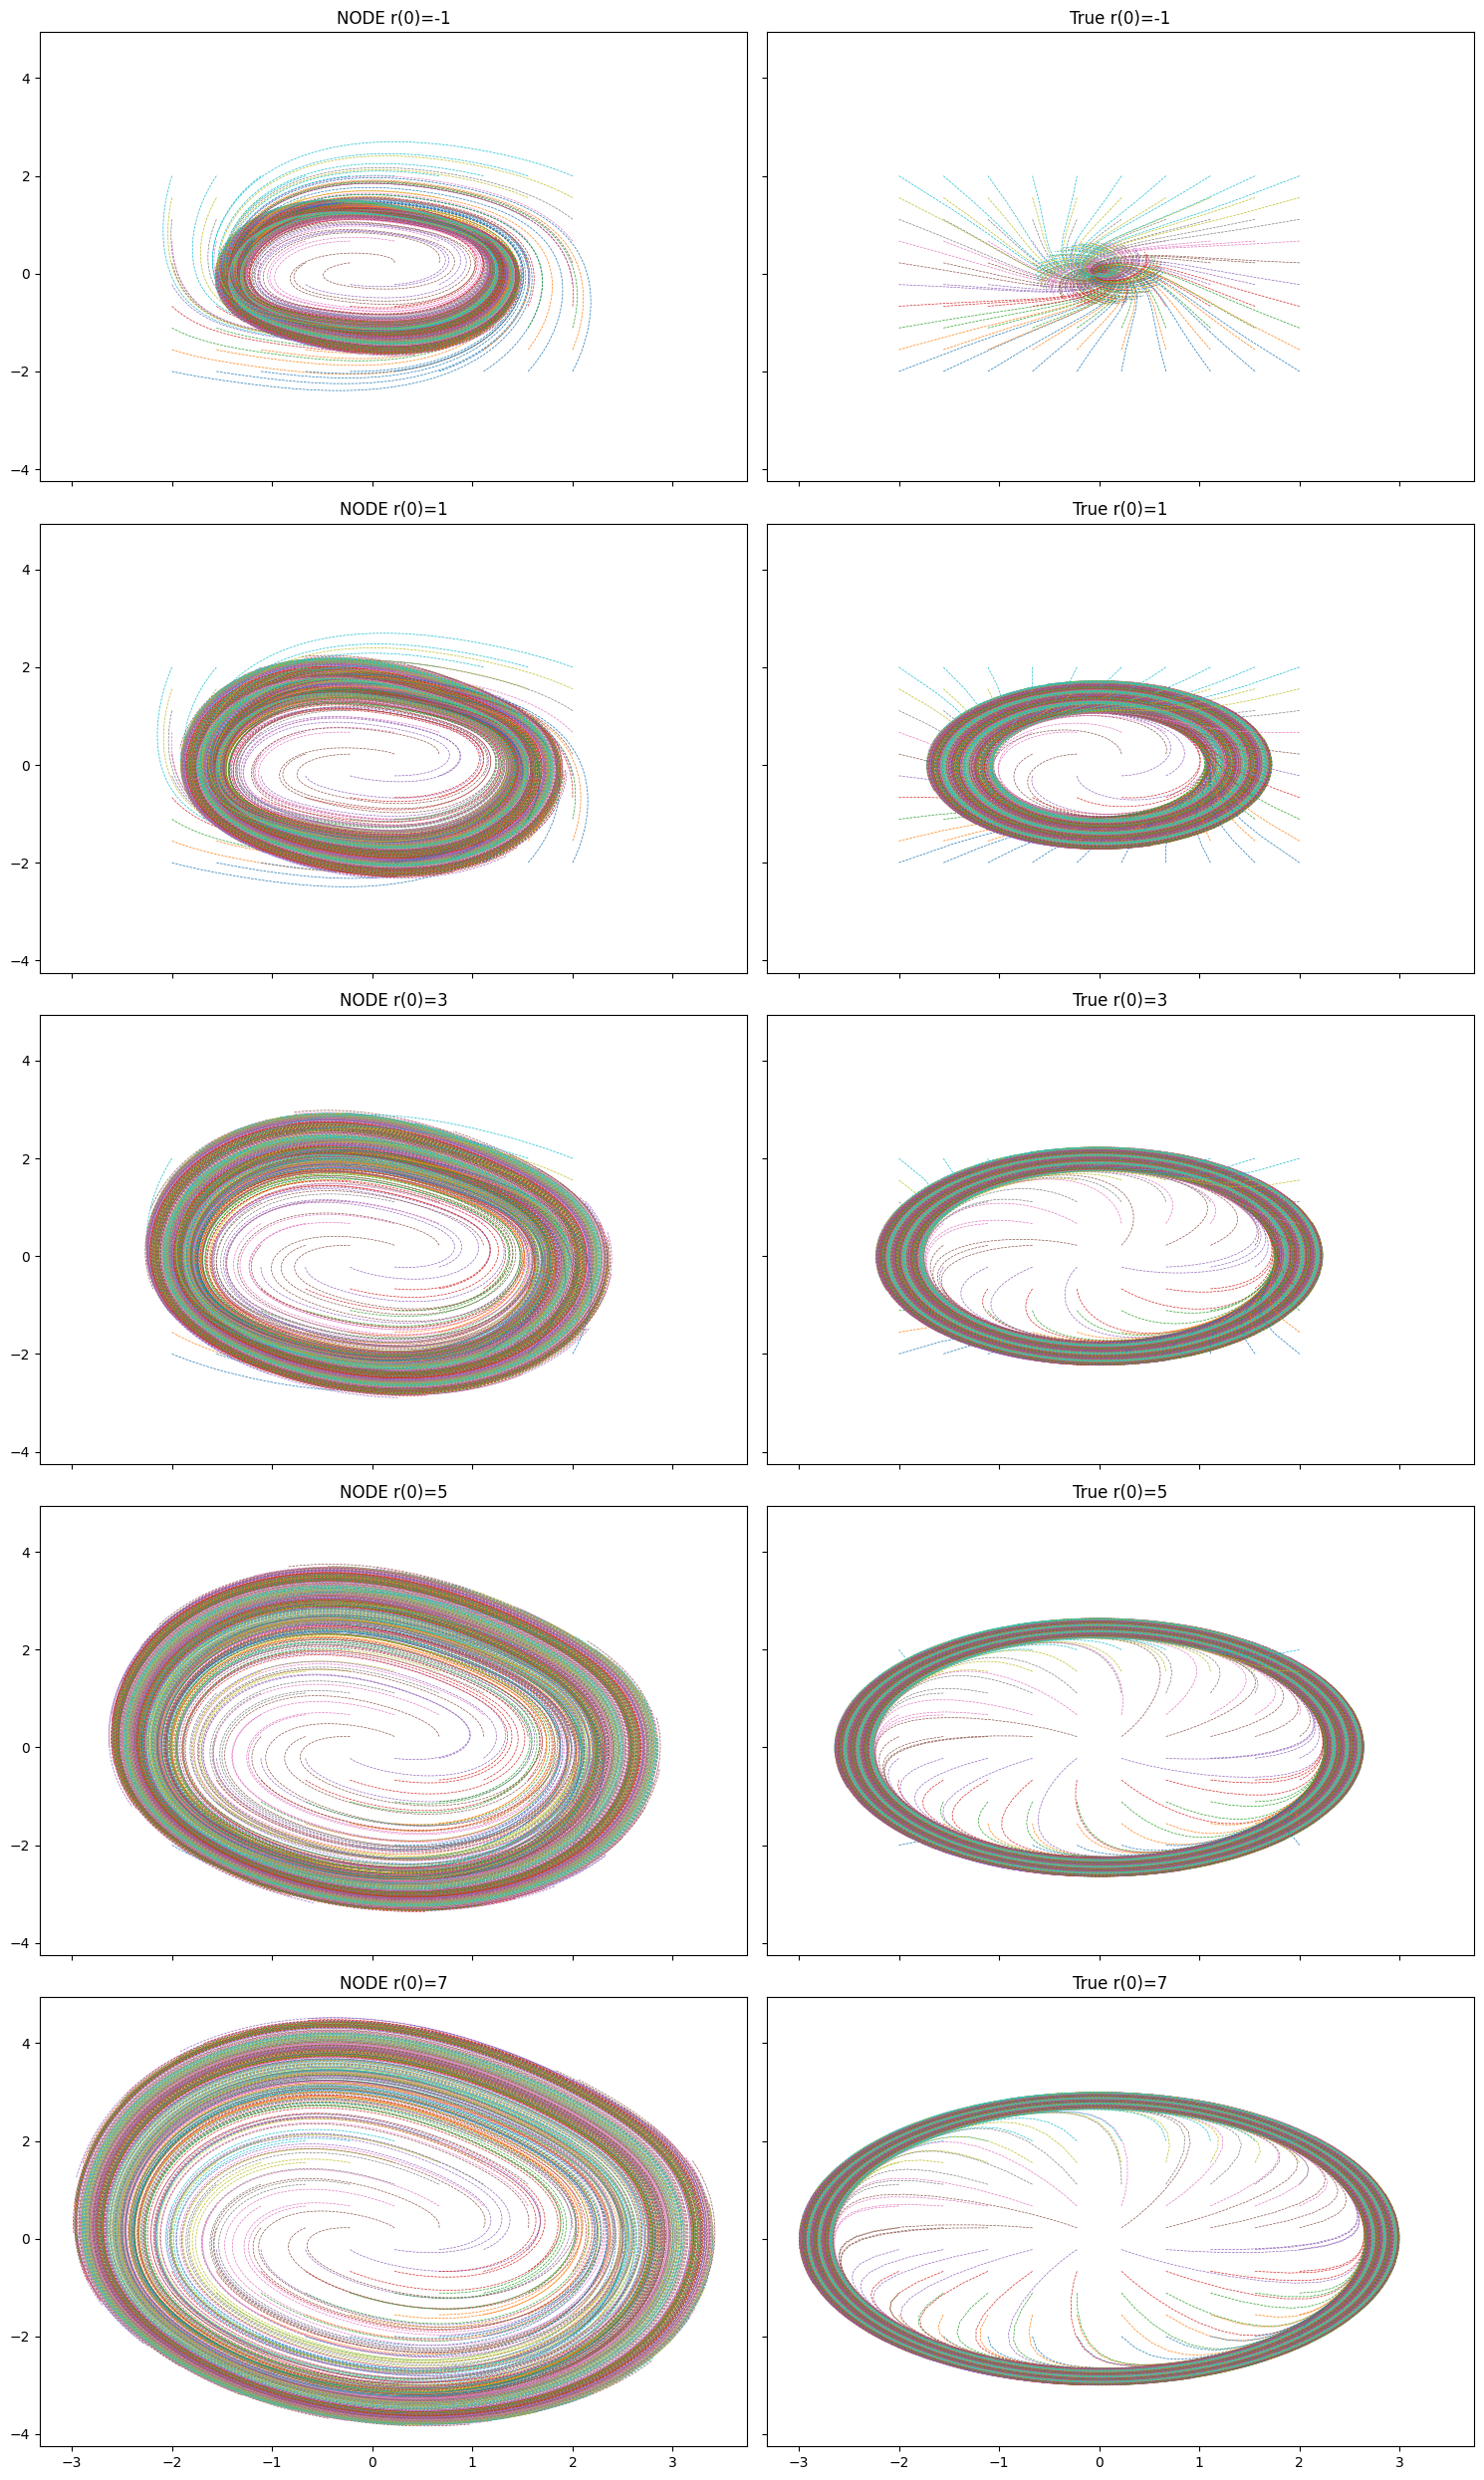

In [ ]:
r_plots = [-1, 1, 3, 5, 7]
fig, axes = plt.subplots(len(r_plots), 2, figsize=(15, 5*len(r_plots)), sharex=True, sharey=True)

for i, r in enumerate(r_plots):
    axes[i, 0].plot(node_data[:, pts[:, 2] == r, 0].detach().numpy(),
                    node_data[:, pts[:, 2] == r, 1].detach().numpy(),
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 1].plot(true_data[:, pts[:, 2] == r, 0].detach().numpy(),
                    true_data[:, pts[:, 2] == r, 1].detach().numpy(),
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 0].set_title(f"NODE r(0)={r}")
    axes[i, 1].set_title(f"True r(0)={r}")

plt.tight_layout()
plt.show()

torch.Size([100, 3])

In [ ]:
def odewrapper2(t, x):
    out = model(t, x)
    out[:, 2] = 2*out[:, 2]
    return out

def odewrapper3(t, x):
    out = model(t, x)
    return out

def odewrapper(t, x):
    out = model(t, x)
    out[:, 2] = torch.zeros_like(out[:, 2])
    #out[:, 2] = 2*out[:, 2]
    return out

In [ ]:
node_data_static = odeint(odewrapper, pts[pts[:, 2] == -1, :], t_eval_pred, method='rk4', options={'step_size': dt_pred})
node_data_dynamic = odeint(odewrapper3, pts[pts[:, 2] == 2, :], t_eval_pred, method='rk4', options={'step_size': dt_pred})
node_data_fast = odeint(odewrapper2, pts[pts[:, 2] == 2, :], t_eval_pred, method='rk4', options={'step_size': dt_pred})

Text(0.5, 1.0, '$2 \\dot \\rho$')

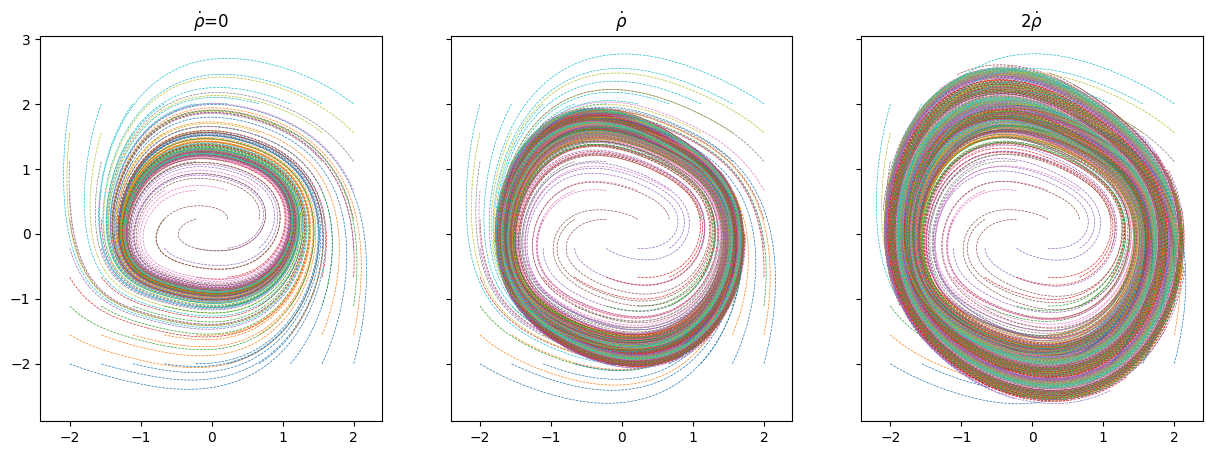

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
axes[0].plot(node_data_static[:, :,  0].detach().numpy(),
                node_data_static[:, :,  1].detach().numpy(),
                linewidth=0.5, alpha=1, linestyle='--')
axes[1].plot(node_data_dynamic[:, :, 0].detach().numpy(),
                node_data_dynamic[:, :, 1].detach().numpy(),
                linewidth=0.5, alpha=1, linestyle='--')
axes[2].plot(node_data_fast[:, :, 0].detach().numpy(),
                node_data_fast[:, :, 1].detach().numpy(),
                linewidth=0.5, alpha=1, linestyle='--')
axes[0].set_title(r'$\dot \rho$'+f"=0")
axes[1].set_title(r'$\dot \rho$')
axes[2].set_title(r'$2 \dot \rho$')

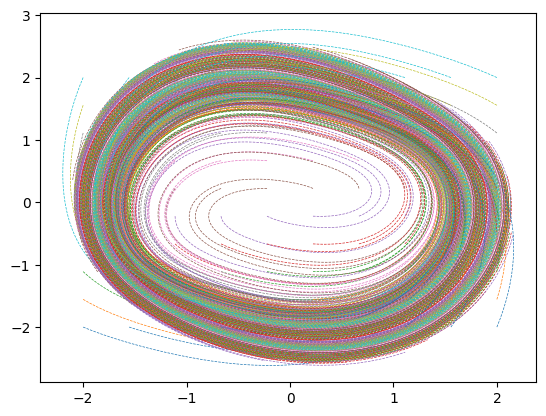

In [54]:
plt.plot(node_data_static[:, :, 0].detach().numpy(), node_data_static[:, :, 1].detach().numpy(),
          linewidth=0.5, alpha=1, linestyle='--')